In [1]:
from tqdm.notebook import tqdm_notebook

import matplotlib
import matplotlib.pyplot as plt

import cv2
import os
from pathlib import Path
from scipy import io as spio
import numpy as np

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [2]:
if os.name == 'nt':
    repo_path = Path(".").absolute().parent
    data_path = Path("D:/Datas/") / "cardataset"
else:    
    repo_path = Path(".").absolute().parent
    data_path = repo_path.parent / "data" / "cardataset"

In [3]:
mat_file = spio.loadmat(data_path / "cars_annos.mat")
annotations = mat_file["annotations"].reshape(-1)

*_, cls, _ = list(zip(*annotations))
cls_array = np.array(cls).reshape(-1)

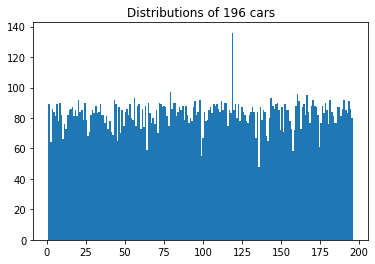

In [4]:
n_cars = len(np.unique(cls_array))

plt.hist(cls_array, bins=n_cars)
plt.title(f"Distributions of {n_cars} cars")
plt.show()

In [78]:
def collect_preprocessing(annotations):     
    # when plotting need: x_min, y_min, x_max, y_max -> y_min, x_min, y_max, x_max

    df = [["img_path", "width", "height", "class", "xmin", "ymin", "xmax", "ymax"]]
    for i, line in tqdm_notebook(enumerate(annotations, 1), total=len(annotations)):
        img_path, xmin, ymin, xmax, ymax, cls, _ = map(lambda x: list(x)[0], line)
    
        image = cv2.imread(str(data_path / img_path))
        height, width, _ = image.shape
        
        df.append([img_path, width, height, int(cls), int(xmin), int(ymin), int(xmax), int(ymax)])
    return df


annotations_clean = np.array(
    collect_preprocessing(annotations)
)

with (data_path / "car_ims_labels.csv").open("w") as file:
    np.savetxt(file, annotations_clean, fmt="%s",delimiter=",")

split 10% of each class

In [305]:
ratio = 0.1
_, counts = np.unique(cls_array, return_counts=True)
test_numbers = (counts * ratio).astype(np.int8)

test_indices = []
count_idx = 0
for total, num in zip(counts, test_numbers):
    idx = np.random.choice(np.arange(count_idx, count_idx+total), size=(num,), replace=False)
    test_indices.extend(idx.tolist())
    count_idx += total
    
test_indices = np.array(test_indices)
test_indices.sort()
train_indices = np.arange(counts.sum())[~np.isin(np.arange(counts.sum()), test_indices)]

train_dataset = annotations_clean[1:][train_indices]
test_dataset = annotations_clean[1:][test_indices]

with (data_path / "car_ims_train_labels.csv").open("w", encoding="utf-8") as file:
    np.savetxt(file, train_dataset, fmt="%s",delimiter=",")

with (data_path / "car_ims_train_labels.csv").open("w", encoding="utf-8") as file:
    np.savetxt(file, test_dataset, fmt="%s",delimiter=",")

create category index and dictionary

In [5]:
class_names = mat_file["class_names"].reshape(-1)
# class_names = list(map(lambda x: list(x)[0], class_names))
# class_names.insert(0, "__background__")

category_index = {i: {"id": i, "name": list(x)[0]} for i, x in enumerate(class_names, 1)}
cate_dicts = {v["id"]: v["name"] for v in category_index.values()}

In [6]:
from object_detection.protos.string_int_label_map_pb2 import StringIntLabelMap, StringIntLabelMapItem
from google.protobuf import text_format

def convert_classes(classes, start=1):
    msg = StringIntLabelMap()
    for i, name in enumerate(classes, start=start):
        msg.item.append(StringIntLabelMapItem(id=i, name=name))

    text = str(text_format.MessageToBytes(msg, as_utf8=True), "utf-8")
    return text

In [7]:
label_map_path = data_path / "label_map.pbtxt"
labels = list(cate_dicts.values())
txt = convert_classes(labels)
with label_map_path.open("w") as file:
    file.write(txt)

convert it to tfrecord form

In [8]:
def create_tf_example(annotation, cate_dicts, data_path):
    """
    only single object in the image so didn't use group
    """
    img_path = annotation[0]
    width, height, cls, xmin, ymin, xmax, ymax = map(int, annotation[1:]) 
    filename = bytes(img_path.split("/")[-1], encoding="utf-8")
    encoded_img = tf.io.gfile.GFile(str(data_path / img_path), "rb").read()
    
    image_format = b"jpg"
    xmins = [xmin/width]
    xmaxs = [xmax/width]
    ymins = [ymin/height]
    ymaxs = [ymax/height]
    classes_text = [bytes(cate_dicts[cls], encoding="utf-8")]
    classes = [cls]

    feature={
        "image/height": dataset_util.int64_feature(height),
        "image/width": dataset_util.int64_feature(width),
        "image/filename": dataset_util.bytes_feature(filename),
        "image/source_id": dataset_util.bytes_feature(filename),
        "image/encoded": dataset_util.bytes_feature(encoded_img),
        "image/format": dataset_util.bytes_feature(image_format),
        "image/object/bbox/xmin": dataset_util.float_list_feature(xmins),
        "image/object/bbox/xmax": dataset_util.float_list_feature(xmaxs),
        "image/object/bbox/ymin": dataset_util.float_list_feature(ymins),
        "image/object/bbox/ymax": dataset_util.float_list_feature(ymaxs),
        "image/object/class/text": dataset_util.bytes_list_feature(classes_text),
        "image/object/class/label": dataset_util.int64_list_feature(classes),
    }
    tf_example = tf.train.Example(features=tf.train.Features(feature=feature))
    return tf_example

In [9]:
def create_tfrecode(data_path, cate_dicts, dataset_csv, outputfile):
    tf_writer = tf.io.TFRecordWriter(str(data_path / outputfile))
    for annotation in dataset_csv:
        tf_example = create_tf_example(annotation, cate_dicts, data_path)
        tf_writer.write(tf_example.SerializeToString())
    tf_writer.close()
    print("Done!")

In [310]:
create_tfrecode(data_path, cate_dicts, dataset_csv=train_dataset, outputfile="train.record")
create_tfrecode(data_path, cate_dicts, dataset_csv=test_dataset, outputfile="test.record")

Done!
Done!


* bbox_x1: Min x-value of the bounding box, in pixels
* bbox_x2: Max x-value of the bounding box, in pixels
* bbox_y1: Min y-value of the bounding box, in pixels
* bbox_y2: Max y-value of the bounding box, in pixels

# Training

In [32]:
config_name = "ssd_efficientdet_d0_512x512_coco17_tpu-8.config"
model_name = "efficientdet_d0_coco17_tpu-32"

pipeline_config = str(repo_path.parent / "pretrained_model" / "configs" / config_name)
checkpoint_path = str(repo_path.parent / "pretrained_model" / model_name / "checkpoint" / "ckpt-0")
train_tfrecord_path = str(data_path / "train.record")
test_tfrecord_path = str(data_path / "test.record")
label_map_path = str(label_map_path)

In [27]:
config_name = "ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config"
model_name = "ssd_resnet50_v1_fpn_640x640_coco17_tpu-8"

pipeline_config = str(repo_path.parent / "pretrained_model" / "configs" / config_name)
checkpoint_path = str(repo_path.parent / "pretrained_model" / model_name / "checkpoint" / "ckpt-0")
train_tfrecord_path = str(data_path / "train.record")
test_tfrecord_path = str(data_path / "test.record")
label_map_path = str(label_map_path)

In [45]:
from google.protobuf import text_format
from object_detection.protos import pipeline_pb2

batch_size = 4
n_epochs = 3000

change config

In [46]:
def modify_pipline(
        old_config_path, 
        new_config_path, 
        checkpoint_path, 
        label_map_path, 
        train_tfrecord_path, 
        test_tfrecord_path,
        num_classes,
        batch_size,
        n_epochs
    ):
    pipeline = pipeline_pb2.TrainEvalPipelineConfig()                                                                                                                                                                                                          
    
    with tf.io.gfile.GFile(old_config_path, "r") as f:                                                                                                                                                                                                                     
        proto_str = f.read()                                                                                                                                                                                                                                          
        text_format.Merge(proto_str, pipeline)
        
    pipeline.model.ssd.num_classes = num_classes
    pipeline.model.ssd.freeze_batchnorm = True
    
    pipeline.train_config.fine_tune_checkpoint_type = "detection"
    pipeline.train_config.use_bfloat16 = False
    pipeline.train_config.batch_size = batch_size
    pipeline.train_config.num_steps = n_epochs
    
    pipeline.train_config.fine_tune_checkpoint = checkpoint_path
    pipeline.train_input_reader.label_map_path = label_map_path
    pipeline.train_input_reader.tf_record_input_reader.input_path[:] = [train_tfrecord_path]
    
    pipeline.eval_input_reader[0].label_map_path = label_map_path
    pipeline.eval_input_reader[0].tf_record_input_reader.input_path[:] = [test_tfrecord_path]
    
    config_text = text_format.MessageToString(pipeline)
    with tf.io.gfile.GFile(new_config_path, "wb") as f:                                                                                                                                                                                                                       
        f.write(config_text)

In [47]:
new_config_folder = repo_path.parent / "pretrained_model" / "mymodel"
if not new_config_folder.exists():
    new_config_folder.mkdir()

new_config_path = str(new_config_folder / "ssd_efficientdet_d0_512x512_coco17_custom.config")
#new_config_path = str(new_config_folder / "ssd_resnet50_v1_fpn_640x640_coco17_custom.config")

In [48]:
print(new_config_folder)
print(new_config_path)

C:\Users\simon\Desktop\Codes\pretrained_model\mymodel
C:\Users\simon\Desktop\Codes\pretrained_model\mymodel\ssd_efficientdet_d0_512x512_coco17_custom.config


In [49]:
modify_pipline(
    old_config_path=pipeline_config, 
    new_config_path=new_config_path, 
    checkpoint_path=checkpoint_path, 
    label_map_path=label_map_path, 
    train_tfrecord_path=train_tfrecord_path, 
    test_tfrecord_path=test_tfrecord_path,
    num_classes=len(category_index),
    batch_size=batch_size,
    n_epochs=n_epochs
)

```
python .\models\research\object_detection\model_main_tf2.py --model_dir=C:\Users\simon\Desktop\Codes\pretrained_model\mymodel --pipeline_config_path=C:\\Users\\simon\\Desktop\\Codes\\pretrained_model\\mymodel\\ssd_efficientdet_d0_512x512_coco17_custom.config
```
```
python .\models\research\object_detection\model_main_tf2.py --model_dir=C:\Users\simon\Desktop\Codes\pretrained_model\mymodel --pipeline_config_path=C:\\Users\\simon\\Desktop\\Codes\\pretrained_model\\mymodel\\ssd_resnet50_v1_fpn_640x640_coco17_custom.config
```

In [ ]:
tensorboard --logdir=C:\Users\simon\Desktop\Codes\pretrained_model\mymodel


In [ ]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
        path: a file path.

    Returns:
        uint8 numpy array with shape (img_height, img_width, 3)
    """
    if isinstance(path, Path):
        path = str(path)
    return cv2.imread(path).astype(np.uint8)
#     img_data = tf.io.gfile.GFile(path, 'rb').read()
#     image = Image.open(BytesIO(img_data))
#     (im_width, im_height) = image.size
#     return np.array(image.getdata()).reshape(
#         (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
        image_np: uint8 numpy array with shape (img_height, img_width, 3)
        boxes: a numpy array of shape [N, 4]
        classes: a numpy array of shape [N]. Note that class indices are 1-based,
            and match the keys in the label map.
        scores: a numpy array of shape [N] or None.  If scores=None, then
            this function assumes that the boxes to be plotted are groundtruth
            boxes and plot all boxes as black with no classes or scores.
        category_index: a dict containing category dictionaries (each holding
            category index `id` and category name `name`) keyed by category indices.
        figsize: size for the figure.
        image_name: a name for the image file.
    """
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax.imshow(image_np_with_annotations)

In [ ]:
idx = np.random.choice(np.arange(len(annotations_dict)))
img_path = annotations_dict[idx]["img_path"]
bbox = annotations_dict[idx]["bbox"]
cls = annotations_dict[idx]["class"]
score = np.array([1.])

In [ ]:
x = load_image_into_numpy_array(data_path / img_path)
plot_detections(x, boxes=bbox, classes=cls, scores=score, category_index=category_index, figsize=(12, 16))